In [1]:
# Standard libraries
from datetime import datetime as dt
from concurrent.futures import ThreadPoolExecutor

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning – scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning – XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

# Machine learning – CatBoost
from catboost import CatBoostClassifier

# Class balancing
from imblearn.over_sampling import SMOTE


import shap


In [2]:
def read_data():
    df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')
    df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
    df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')
    return df_credits, df_atlas, df_payments

def data_cleaning(df_credits, df_payments):
    df_c_negative = df_credits[df_credits['credits']<0]
    df_credits[df_credits.user.isin(df_c_negative.user) == True]

    # IDK what I'm doing with payments
    df_payments[df_payments.user.isin(df_c_negative.user)==True].sort_values(['user','created_at'])
    df_payments.state.unique()
    df_payments[df_payments.user=='STUD54678']
    df_credits[df_credits.user=='STUD54678']

    df_credits_cleaned = df_credits[df_credits['credits']>0]
    df_payments_cleaned = df_payments[df_payments['user'].notna()] # we threw out from payments 2345 observations

    return df_credits_cleaned, df_payments_cleaned

def get_merged_table():
    df_credits, df_atlas, df_payments = read_data()
    _, df_payments_cleaned = data_cleaning(df_credits, df_payments)
    df_merge_full = pd.merge(df_payments_cleaned, df_atlas, how='inner', left_on='user', right_on='user_id')
    df_merge_full.rename(columns={'credits_x':'credits_payments', 'credits_y':'credits_credits'})
    df_merge_full = pd.get_dummies(df_merge_full, columns=['type'], drop_first=True)
    df_merge_full = df_merge_full.astype({col: int for col in df_merge_full.select_dtypes(include='bool').columns})

    df_merge_full['created_at'] = pd.to_datetime(df_merge_full['created_at'])

    df_merge_full['day'] = df_merge_full['created_at'].dt.day
    df_merge_full['month'] = df_merge_full['created_at'].dt.month
    df_merge_full['year'] = df_merge_full['created_at'].dt.year
    df_merge_full['weekday'] = df_merge_full['created_at'].dt.weekday

    print(df_merge_full[df_merge_full.year.isin([2025])].shape[0])
    print(df_merge_full[df_merge_full.year.isin([2017])].shape[0])

    df_merge_full = df_merge_full[(df_merge_full['year'] != 2017) & (df_merge_full['year'] != 2025)]
    df_merge_full = df_merge_full.drop(columns=['year'])
    df_merge_full = df_merge_full.drop(columns=['created_at'])
    return df_merge_full

# split dataset into three categories
def get_split_values(df_merge_full, value:int):
    col_name = f'credits_{value}+'
    df_modeling = df_merge_full.drop(columns=['id', 'changed_at', 'user', 'batch', 'state', 'user_id'])
    df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)
    df_modeling = df_modeling.drop(columns=['credits'])

    fig = px.bar(pd.DataFrame(df_modeling[col_name].value_counts().reset_index()), x=col_name, y='count', title='Credits Category Distribution')
    fig.show()
    
    df_modeling = df_modeling[df_modeling[col_name].isnull()==False] # clean data from null values
    return df_modeling, col_name

def split_data(X, y, test_size=0.2, stratify=True, random_state=42):
    """
    Split data into training and testing sets with optional stratification.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        test_size (float): Proportion of data to use as test set.
        stratify (bool): Whether to stratify split based on y.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple: (X_train, X_test, y_train, y_test)
    """
    return train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=random_state
    )

def get_smote_train(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

def compute_vif_column(X_values, i, col_name):
    print(f"Computing VIF for column: {col_name}")
    return variance_inflation_factor(X_values, i)

def remove_high_vif_parallel(X, thresh=10.0, verbose=True, n_iterations=10, max_workers=4):
    """
    Removes columns with high VIF using multithreading to speed up VIF computation.
    """
    X = X.copy()
    X_numeric = X.select_dtypes(include='number')
    dropped = []
    iterations = 0

    while iterations < n_iterations:
        print(f'This is in iteration number: {iterations}')
        X_values = X_numeric.values
        columns = list(X.columns)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            vifs = list(executor.map(
                lambda pair: compute_vif_column(X_values, pair[0], pair[1]),
                enumerate(columns)
            ))

        vif_series = pd.Series(vifs, index=columns)
        max_vif = vif_series.max()

        if max_vif > thresh:
            drop_col = vif_series.idxmax()
            if verbose:
                print(f"Dropping '{drop_col}' with VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_col])
            dropped.append(drop_col)
        else:
            break

        iterations += 1

    return X, dropped

In [3]:
df_merge_full = get_merged_table()
df_modeling, colname = get_split_values(df_merge_full, 600)

y = df_modeling[colname]
X = df_modeling.drop(columns=[colname])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , train_size=0.8, random_state=42)

X_train_smote, y_train_smote = get_smote_train(X_train, y_train)

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['day'] = df_merge_full['created_at'].dt.day
/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['month'] = df_merge_full['created_at'].dt.month
/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

3956
34


/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



In [ ]:
_, _, df_payments = read_data()
df_payments[(df_payments['user'].isna())&(df_payments['credits']>=500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits']<500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits'].isna())]

df_payments[df_payments['id'].isnull()]

# Modeling

# Grid Search

In [73]:
# catboost clf
grid_cat = {
    'depth':[5,10,15]
}

model_cat = CatBoostClassifier(
    iterations=800,
    eval_metric='Accuracy',
    verbose=200, # control how often the model will print out output - e.g. when verbose is set to 50 = every 50 iteretion print out current status,
    loss_function='CrossEntropy',
    learning_rate=0.1
)

grid_cat = GridSearchCV(model_cat, grid_cat, cv=3, scoring='accuracy')
grid_cat.fit(X_train_smote, y_train_smote, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.7375034	test: 0.5963303	best: 0.5963303 (0)	total: 17.7ms	remaining: 14.1s
200:	learn: 0.9614406	test: 0.7623416	best: 0.7627785 (195)	total: 1.81s	remaining: 5.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7693315858
bestIteration = 331

Shrink model to first 332 iterations.
0:	learn: 0.6430544	test: 0.6026649	best: 0.6026649 (0)	total: 9.23ms	remaining: 7.37s
200:	learn: 0.8392093	test: 0.7688947	best: 0.7688947 (200)	total: 2.06s	remaining: 6.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7717343818
bestIteration = 235

Shrink model to first 236 iterations.
0:	learn: 0.6315932	test: 0.6192661	best: 0.6192661 (0)	total: 10.5ms	remaining: 8.39s
200:	learn: 0.8414925	test: 0.7616863	best: 0.7645260 (175)	total: 1.73s	remaining: 5.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7645259939
bestIteration = 175

Shrink model to first 176 iterations.
0:	learn: 0.7915516	test: 0.6671035	best: 0.6671035 (0)	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x30aeb7160>,
             param_grid={'depth': [5, 10, 15]}, scoring='accuracy')

In [69]:
grid_cat.best_params_

{'depth': 12, 'learning_rate': 0.1}

In [75]:
# XGBClassifier

xgb.set_config(verbosity=1)

param_grid = {
    'n_estimators': np.array(range(100, 2000, 100)),
    'max_depth': np.array(range(1, 20, 1)),
    'learning_rate': np.array(range(5, 25, 5))/100,
    'eval_metric': ['logloss', 'error', 'auc'],
}

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

grid_XGB = RandomizedSearchCV(model, param_grid, cv=3, scoring='accuracy', n_iter=20, n_jobs=-1)
grid_XGB.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)], verbose=200)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.41547


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.45107


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.48143


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.55393


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.56275


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.55712


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31564


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.39537


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.36872


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.55393
[200]	validation_0-error:0.24421
[200]	validation_0-error:0.26453
[200]	validation_0-error:0.26212
[200]	validation_0-auc:0.65656
[200]	validation_0-auc:0.71982
[200]	validation_0-auc:0.72691
[200]	validation_0-error:0.22892
[200]	validation_0-error:0.22630
[200]	validation_0-auc:0.65656
[400]	validation_0-error:0.24093
[200]	validation_0-error:0.23569
[400]	validation_0-error:0.25055
[400]	validation_0-error:0.25448
[400]	validation_0-auc:0.66945
[400]	validation_0-auc:0.74195
[400]	validation_0-auc:0.74619
[600]	validation_0-error:0.23657
[400]	validation_0-auc:0.66945
[600]	validation_0-error:0.25120
[400]	validation_0-error:0.22761
[600]	validation_0-error:0.25295
[400]	validation_0-error:0.23154
[400]	validation_0-error:0.23744
[600]	validation_0-auc:0.67203
[600]	validation_0-auc:0.74886
[600]	validation_0-auc:0.75113
[800]	validation_0-error:0.23373
[800]	validation_0-error:0.24334
[600]	validation_0-auc:0.67203
[800]	validation_0-error:0.24967
[600]

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.56275
[1200]	validation_0-auc:0.66596
[1200]	validation_0-auc:0.75432
[1200]	validation_0-auc:0.75351
[1399]	validation_0-error:0.23067
[1000]	validation_0-error:0.22652
[1299]	validation_0-auc:0.66533
[1399]	validation_0-error:0.23897
[1299]	validation_0-auc:0.75514
[1000]	validation_0-error:0.23111
[1399]	validation_0-error:0.24443
[1000]	validation_0-error:0.24268
[1299]	validation_0-auc:0.75331


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.55712


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.26103
[200]	validation_0-auc:0.71982


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.27960


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.28462


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.27283


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31324
[1200]	validation_0-error:0.22674
[200]	validation_0-auc:0.72691
[1200]	validation_0-error:0.23198
[1200]	validation_0-error:0.24203
[400]	validation_0-auc:0.74195
[200]	validation_0-error:0.22848
[200]	validation_0-error:0.22892
[400]	validation_0-auc:0.74619
[1399]	validation_0-error:0.22652
[200]	validation_0-error:0.23569
[200]	validation_0-error:0.24159
[600]	validation_0-auc:0.74886
[200]	validation_0-error:0.23526
[1399]	validation_0-error:0.23285
[1399]	validation_0-error:0.23875


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.32787
[299]	validation_0-error:0.22717


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.26627
[299]	validation_0-error:0.23569


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29358
[600]	validation_0-auc:0.75113


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[400]	validation_0-error:0.22805
[0]	validation_0-error:0.29401
[800]	validation_0-auc:0.75318


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.58596
[400]	validation_0-error:0.23657
[400]	validation_0-error:0.24006
[800]	validation_0-auc:0.75279
[200]	validation_0-error:0.24050
[999]	validation_0-auc:0.75479
[600]	validation_0-error:0.22805
[200]	validation_0-error:0.22870
[200]	validation_0-auc:0.66584


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.56180
[299]	validation_0-error:0.23788
[200]	validation_0-error:0.23307
[200]	validation_0-error:0.23394
[999]	validation_0-auc:0.75327
[699]	validation_0-error:0.22827
[299]	validation_0-error:0.22870
[600]	validation_0-error:0.23591


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.58276
[600]	validation_0-error:0.24028


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.41547
[400]	validation_0-auc:0.66875


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.45107
[299]	validation_0-error:0.23460
[200]	validation_0-auc:0.76004


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.48143
[299]	validation_0-error:0.23438
[699]	validation_0-error:0.23591
[699]	validation_0-error:0.24006


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.65237


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69746
[200]	validation_0-auc:0.75364
[200]	validation_0-error:0.24640


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.70043
[200]	validation_0-error:0.26103
[200]	validation_0-error:0.27108


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.62561
[600]	validation_0-auc:0.66615
[400]	validation_0-auc:0.75919
[400]	validation_0-error:0.23810
[400]	validation_0-auc:0.75455
[400]	validation_0-error:0.25382
[200]	validation_0-auc:0.71812
[400]	validation_0-error:0.25055
[800]	validation_0-auc:0.66714
[600]	validation_0-auc:0.75743
[200]	validation_0-auc:0.69342
[200]	validation_0-auc:0.75873
[600]	validation_0-error:0.23482
[200]	validation_0-auc:0.75103
[600]	validation_0-error:0.25055
[600]	validation_0-error:0.24640
[600]	validation_0-auc:0.75145
[400]	validation_0-auc:0.71219
[1000]	validation_0-auc:0.66768
[800]	validation_0-auc:0.75594
[800]	validation_0-error:0.23482
[400]	validation_0-auc:0.69015
[800]	validation_0-error:0.24487
[800]	validation_0-error:0.24356
[800]	validation_0-auc:0.74945
[400]	validation_0-auc:0.75845
[400]	validation_0-auc:0.74957
[1000]	validation_0-error:0.23242
[1000]	validation_0-auc:0.75415
[1200]	validation_0-auc:0.66813
[600]	validation_0-auc:0.70941
[1000]	validation

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.63484
[1200]	validation_0-error:0.23242
[600]	validation_0-auc:0.75758
[1200]	validation_0-auc:0.75447
[1399]	validation_0-auc:0.66842
[600]	validation_0-auc:0.74801
[1200]	validation_0-error:0.23351
[1200]	validation_0-error:0.24137
[800]	validation_0-auc:0.70875


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.63233
[1200]	validation_0-auc:0.74704
[1400]	validation_0-error:0.23132
[1400]	validation_0-error:0.23831
[1400]	validation_0-error:0.23438
[200]	validation_0-auc:0.75933
[1399]	validation_0-auc:0.75361
[800]	validation_0-auc:0.75713
[1000]	validation_0-auc:0.70826
[800]	validation_0-auc:0.74767


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29642
[1600]	validation_0-error:0.23045
[1399]	validation_0-auc:0.74492
[200]	validation_0-auc:0.75900
[1600]	validation_0-error:0.23504
[1600]	validation_0-error:0.23700


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.35321
[400]	validation_0-auc:0.75621
[1000]	validation_0-auc:0.75683
[1800]	validation_0-error:0.22914
[1200]	validation_0-auc:0.70715
[1000]	validation_0-auc:0.74693
[1800]	validation_0-error:0.23285
[1800]	validation_0-error:0.23613
[200]	validation_0-error:0.23176
[1899]	validation_0-error:0.22979
[400]	validation_0-auc:0.75609
[1899]	validation_0-error:0.22979
[1899]	validation_0-error:0.23635


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.36806
[200]	validation_0-error:0.22761


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.64466
[599]	validation_0-auc:0.75536
[1400]	validation_0-auc:0.70588


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.67613
[1200]	validation_0-auc:0.75632


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66595
[1200]	validation_0-auc:0.74618
[400]	validation_0-error:0.22805
[599]	validation_0-auc:0.75496
[200]	validation_0-error:0.23001
[400]	validation_0-error:0.23285


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.65229
[1599]	validation_0-auc:0.70486
[200]	validation_0-auc:0.68790
[1400]	validation_0-auc:0.75628
[200]	validation_0-auc:0.75583
[1400]	validation_0-auc:0.74619


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69094
[600]	validation_0-error:0.22936
[200]	validation_0-auc:0.74589
[400]	validation_0-error:0.23285
[600]	validation_0-error:0.23373
[400]	validation_0-auc:0.68564
[1599]	validation_0-auc:0.75625
[200]	validation_0-auc:0.72109
[1599]	validation_0-auc:0.74563
[800]	validation_0-error:0.22848
[400]	validation_0-auc:0.75496


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69687
[400]	validation_0-auc:0.74555


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31564
[200]	validation_0-auc:0.76068
[600]	validation_0-auc:0.68543
[800]	validation_0-error:0.23460
[600]	validation_0-error:0.23285
[400]	validation_0-auc:0.71503
[1000]	validation_0-error:0.22805
[600]	validation_0-auc:0.75446
[600]	validation_0-auc:0.74634
[200]	validation_0-error:0.23438
[800]	validation_0-auc:0.68449
[200]	validation_0-auc:0.75379
[400]	validation_0-auc:0.76023
[1000]	validation_0-error:0.23438
[800]	validation_0-error:0.23045
[600]	validation_0-auc:0.71161
[1200]	validation_0-error:0.22805
[800]	validation_0-auc:0.75435
[400]	validation_0-error:0.23111
[800]	validation_0-auc:0.74533
[1000]	validation_0-auc:0.68454
[1200]	validation_0-error:0.23591
[1000]	validation_0-error:0.23111
[400]	validation_0-auc:0.75242
[600]	validation_0-auc:0.75893
[800]	validation_0-auc:0.71012
[1099]	validation_0-auc:0.68428
[1400]	validation_0-error:0.22848
[1000]	validation_0-auc:0.75419
[600]	validation_0-error:0.22892


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.39537
[1000]	validation_0-auc:0.74507
[1099]	validation_0-auc:0.75409
[1099]	validation_0-auc:0.74477
[1400]	validation_0-error:0.23547
[1200]	validation_0-error:0.23111
[1599]	validation_0-error:0.22783
[1000]	validation_0-auc:0.70776
[0]	validation_0-error:0.36872


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[800]	validation_0-auc:0.75879
[800]	validation_0-error:0.22870
[600]	validation_0-auc:0.75120


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.67237
[200]	validation_0-error:0.22543


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.67723
[1599]	validation_0-error:0.23678
[1400]	validation_0-error:0.23154
[200]	validation_0-error:0.23438
[1199]	validation_0-auc:0.70690
[1000]	validation_0-error:0.22848
[400]	validation_0-error:0.23023


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-auc:0.75890
[0]	validation_0-logloss:0.67679
[800]	validation_0-auc:0.75073


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.25928
[200]	validation_0-logloss:0.84498
[400]	validation_0-error:0.22870
[1599]	validation_0-error:0.23198
[1200]	validation_0-error:0.22914
[600]	validation_0-error:0.22761
[200]	validation_0-logloss:0.57924


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1199]	validation_0-auc:0.75868
[0]	validation_0-error:0.27479
[1000]	validation_0-auc:0.75060
[200]	validation_0-error:0.22630
[400]	validation_0-logloss:1.00725


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.28178
[600]	validation_0-error:0.23329
[200]	validation_0-logloss:0.58383
[1399]	validation_0-error:0.22805
[800]	validation_0-error:0.23045


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.54324
[400]	validation_0-logloss:0.63992
[1199]	validation_0-auc:0.74994
[400]	validation_0-error:0.22827
[600]	validation_0-logloss:1.09382
[800]	validation_0-error:0.23722
[200]	validation_0-error:0.24050
[1000]	validation_0-error:0.23263
[200]	validation_0-auc:0.62590


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.55131
[200]	validation_0-error:0.23810
[400]	validation_0-logloss:0.64399
[600]	validation_0-error:0.22783
[800]	validation_0-logloss:1.15107
[400]	validation_0-auc:0.63760
[600]	validation_0-logloss:0.67791
[200]	validation_0-auc:0.67656
[1000]	validation_0-error:0.23678
[1200]	validation_0-error:0.23416
[400]	validation_0-error:0.23897
[800]	validation_0-error:0.22805
[600]	validation_0-auc:0.64651
[400]	validation_0-error:0.24225
[400]	validation_0-auc:0.69723
[600]	validation_0-logloss:0.68208
[1000]	validation_0-logloss:1.19406
[1399]	validation_0-error:0.23569
[1200]	validation_0-error:0.23526
[800]	validation_0-logloss:0.70575


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.54600
[800]	validation_0-auc:0.64960
[600]	validation_0-error:0.24334
[600]	validation_0-auc:0.71056
[1000]	validation_0-error:0.22848
[600]	validation_0-error:0.24225
[1200]	validation_0-logloss:1.22927
[1399]	validation_0-error:0.23657
[800]	validation_0-logloss:0.70987
[200]	validation_0-auc:0.67915
[1000]	validation_0-auc:0.65218
[800]	validation_0-auc:0.72033
[1000]	validation_0-logloss:0.72724


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.65694
[1299]	validation_0-logloss:1.24379
[800]	validation_0-error:0.24290
[1200]	validation_0-error:0.22805
[400]	validation_0-auc:0.70147


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.67583
[1200]	validation_0-auc:0.65415
[800]	validation_0-error:0.24115
[1000]	validation_0-auc:0.72962
[1299]	validation_0-error:0.22783
[1000]	validation_0-logloss:0.73173
[200]	validation_0-logloss:0.96268
[1299]	validation_0-auc:0.65534
[1200]	validation_0-logloss:0.74506


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.67495


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.62561
[600]	validation_0-auc:0.71262
[1000]	validation_0-error:0.24181
[299]	validation_0-logloss:1.11517
[1200]	validation_0-auc:0.73328
[200]	validation_0-logloss:0.52212
[1299]	validation_0-logloss:0.75262


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.63485
[1000]	validation_0-error:0.24181
[1299]	validation_0-auc:0.73489
[299]	validation_0-logloss:0.55416
[1200]	validation_0-logloss:0.74918
[800]	validation_0-auc:0.72049
[0]	validation_0-auc:0.63233


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:05:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	validation_0-logloss:0.52340
[200]	validation_0-auc:0.69064
[1200]	validation_0-error:0.24093
[1299]	validation_0-logloss:0.75695
[299]	validation_0-logloss:0.55708
[200]	validation_0-auc:0.75090
[1000]	validation_0-auc:0.72773
[1200]	validation_0-error:0.24159
[1299]	validation_0-error:0.24159
[200]	validation_0-auc:0.74973
[400]	validation_0-auc:0.68841
[1299]	validation_0-error:0.24115
[1200]	validation_0-auc:0.73026
[400]	validation_0-auc:0.75280
[1299]	validation_0-auc:0.73244
[400]	validation_0-auc:0.74810
[600]	validation_0-auc:0.68904
[600]	validation_0-auc:0.75308
[800]	validation_0-auc:0.68880
[600]	validation_0-auc:0.74766
[800]	validation_0-auc:0.75308
[1000]	validation_0-auc:0.68807
[800]	validation_0-auc:0.74709
[1000]	validation_0-auc:0.75286
[1200]	validation_0-auc:0.68798
[1000]	validation_0-auc:0.74647
[1200]	validation_0-auc:0.75333
[1400]	validation_0-auc:0.68793
[1200]	validation_0-auc:0.74594
[1400]	validation_0-auc:0.75304
[1600]	validation_0-auc:0.68752
[1

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:07:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[200]	validation_0-error:0.22084
[299]	validation_0-error:0.21931


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'eval_metric': ['logloss', 'error',
                                                        'auc'],
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   scoring='accuracy')

In [59]:
##### logistic regression model
model_logit = LogisticRegression()
model_logit.fit(X_train_smote, y_train_smote)

##### Decision Tree
param_grid = {
    'max_depth': np.array(range(4, 15, 2)),
    'criterion': ['gini', 'entropy']
}

model_dt = DecisionTreeClassifier(random_state=42)

grid_dt = RandomizedSearchCV(model_dt, param_grid, cv=None, scoring='accuracy', n_iter=10, n_jobs=-1)
grid_dt.fit(X_train_smote, y_train_smote)

##### Random Forest
param_grid = {
    'n_estimators': np.array(range(100, 1000, 300)),
    'max_depth': np.array(range(5, 15, 3)),
    'criterion': ['gini', 'entropy']
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(model_rf, param_grid, cv=None, scoring='accuracy', n_iter=20, n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/joblib/externals/loky/process

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  8, 11, 14]),
                                        'n_estimators': array([100, 400, 700])},
                   scoring='accuracy')

In [4]:
##### Random Forest
param_grid = {
    'n_estimators': np.array(range(100, 1000, 300)),
    'max_depth': np.array(range(5, 15, 3)),
    'criterion': ['gini', 'entropy']
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(model_rf, param_grid, cv=None, scoring='accuracy', n_iter=30, n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  8, 11, 14]),
                                        'n_estimators': array([100, 400, 700])},
                   scoring='accuracy')

In [76]:


def evaluate_model_separate(list_model, list_model_name, X_test, y_test):
    """
    Evaluates classification models and returns:
    - DataFrame with metrics for class '0' and '1'
    - DataFrame with overall accuracy per model
    - Dictionary with confusion matrices per model

    Parameters:
    - list_model: list of trained model objects
    - list_model_name: list of corresponding model names
    - X_test: test features
    - y_test: test labels

    Returns:
    - df_class: DataFrame with metrics for class '0' and '1'
    - df_accuracy: DataFrame with overall accuracy per model
    - cm_dict: Dictionary of confusion matrices {model_name: matrix}
    """
    class_rows = []
    accuracy_rows = []
    cm_dict = {}

    for model, name in zip(list_model, list_model_name):
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        cm_dict[name] = cm  # store confusion matrix in dictionary

        for label, metrics in report.items():
            if label in ['0', '1']:
                class_rows.append({
                    'model': name,
                    'class': label,
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1-score': metrics['f1-score'],
                    'support': metrics['support']
                })
            elif label == 'accuracy':
                accuracy_rows.append({
                    'model': name,
                    'accuracy': metrics
                })

    df_class = pd.DataFrame(class_rows)
    df_accuracy = pd.DataFrame(accuracy_rows)
    return df_class, df_accuracy, cm_dict

In [83]:
df_class


,model,class,precision,recall,f1-score,support
0,Logistic Regression,0,0.798105,0.875794,0.835147,3462.0
1,Logistic Regression,1,0.448010,0.312724,0.368338,1116.0
2,Decision Tree,0,0.834975,0.783362,0.808346,3462.0
3,Decision Tree,1,0.436090,0.519713,0.474244,1116.0
4,Random Forest,0,0.839922,0.871462,0.855401,3462.0
5,Random Forest,1,0.548682,0.484767,0.514748,1116.0
6,CatBoost,0,0.831675,0.893414,0.861440,3462.0
7,CatBoost,1,0.570431,0.439068,0.496203,1116.0
8,XGBoost,0,0.824446,0.902080,0.861517,3462.0
9,XGBoost,1,0.570886,0.404122,0.473242,1116.0


In [82]:
df_accuracy


,model,accuracy
0,Logistic Regression,0.738532
1,Decision Tree,0.719091
2,Random Forest,0.777195
3,CatBoost,0.782656
4,XGBoost,0.780690


In [77]:
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_cat = grid_cat.best_estimator_
best_XGB = grid_XGB.best_estimator_

list_model = [model_logit, best_dt, best_rf, best_cat, best_XGB]
list_model_name = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'XGBoost']

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)

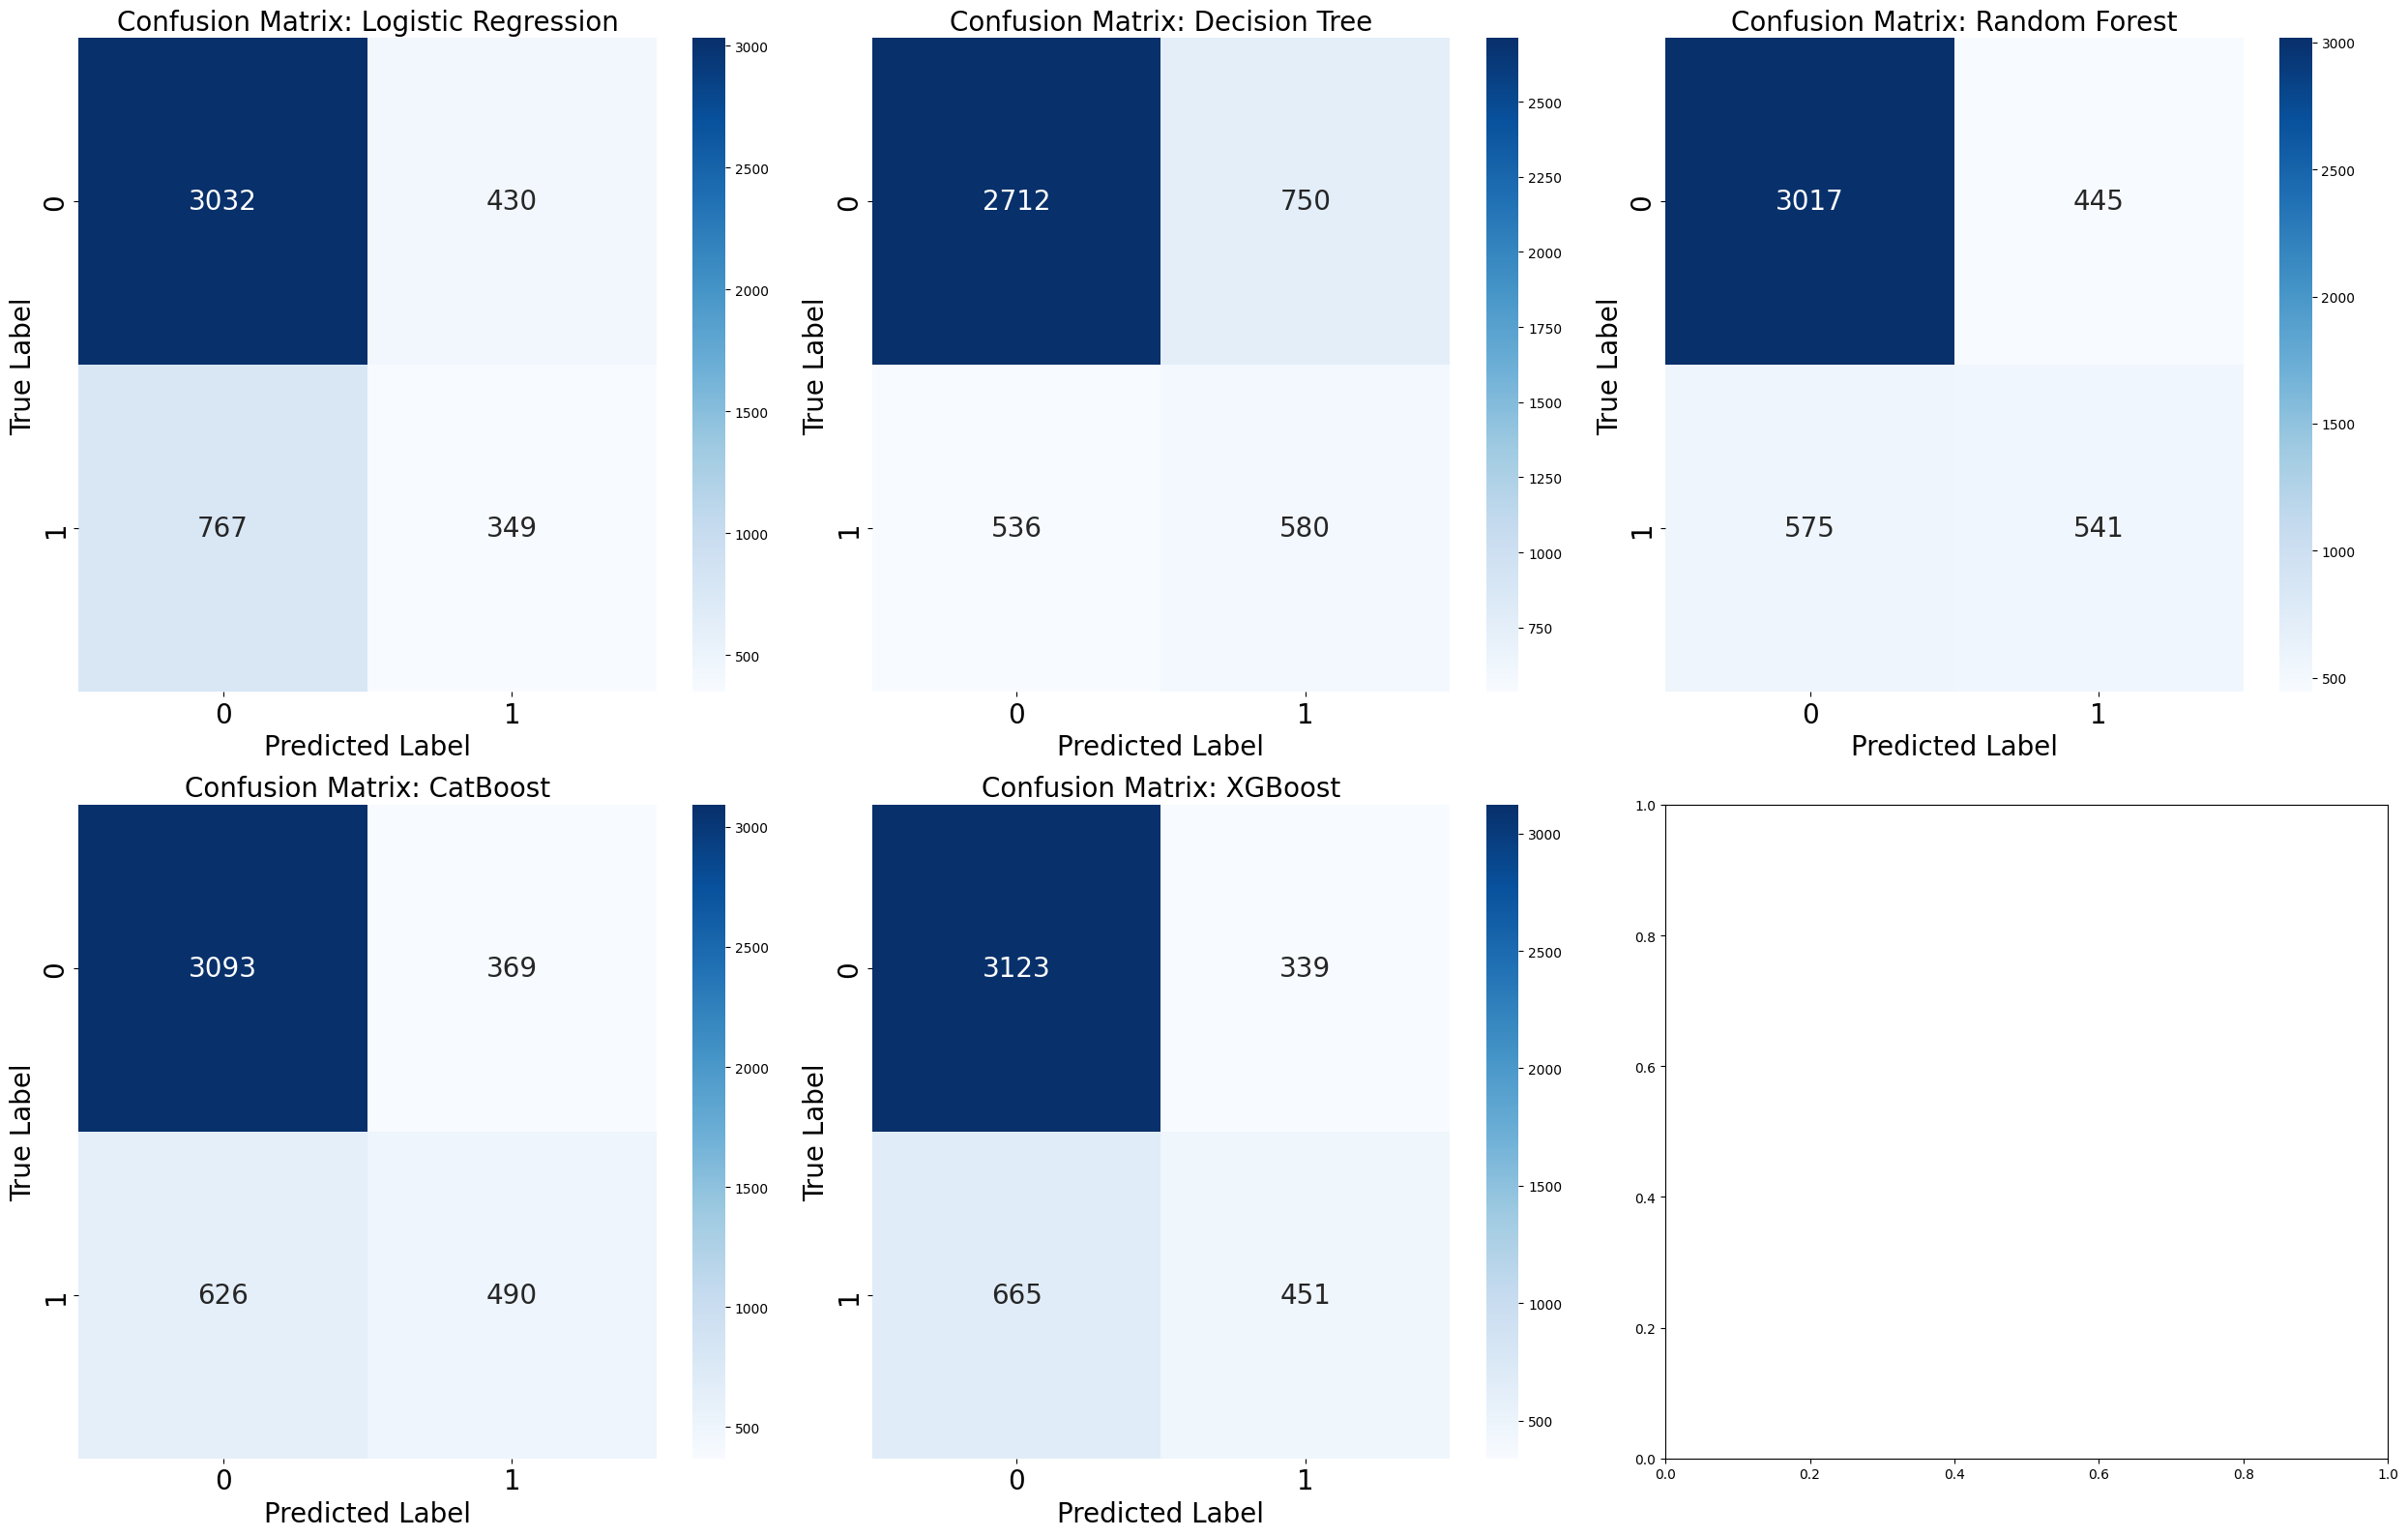

In [94]:

def plot_confusion_matrices(cm_dict, class_labels=['0', '1']):
    """
    Plots confusion matrices stored in a dictionary using Seaborn heatmaps in a dynamic layout.

    Parameters:
    - cm_dict: Dictionary of {model_name: confusion_matrix}
    - class_labels: List of class labels (default ['0', '1'])
    """
    num_models = len(cm_dict)
    rows = 2  # Set the number of rows to 2
    fig, axs = plt.subplots(rows, 3, figsize=(25, 8 * rows))  # Adjust figure size dynamically
    axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array
    for i, (model_name, cm) in enumerate(cm_dict.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i],
                    xticklabels=class_labels, yticklabels=class_labels, annot_kws={'size': 20})  # Increase font size of numeric labels
        axs[i].set_xlabel('Predicted Label', fontsize=20)  # Increase font size of x-axis label
        axs[i].set_ylabel('True Label', fontsize=20)  # Increase font size of y-axis label
        axs[i].tick_params(axis='both', labelsize=20)  # Increase font size of tick labels
        axs[i].set_title(f'Confusion Matrix: {model_name}', fontsize=20)  # Increase font size of title
    plt.tight_layout()
    plt.show()

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)
plot_confusion_matrices(cm_dict)

In [11]:
best_rf = grid_rf.best_estimator_

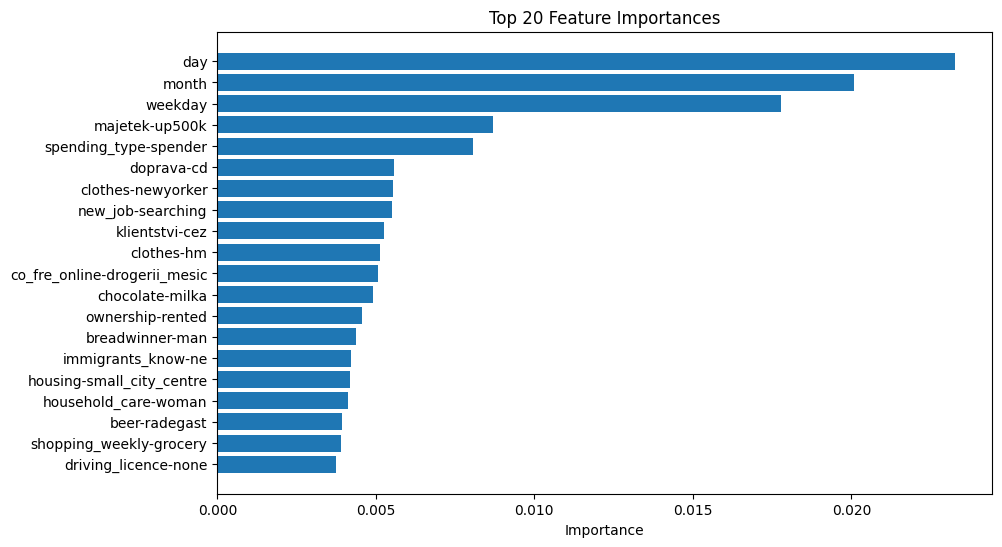

In [12]:
def plot_top_features(model, X_test, top_count=10):
    feature_importances = model.feature_importances_
    feature_names = X_test.columns

    # Sort feature importances and names
    sorted_idx = feature_importances.argsort()[::-1]
    feature_importances_sorted = feature_importances[sorted_idx]
    feature_names_sorted = feature_names[sorted_idx]

    # Select top features
    top_idx = sorted_idx[:top_count]
    feature_importances_top = feature_importances[top_idx]
    feature_names_top = feature_names[top_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names_top, feature_importances_top)
    plt.title(f'Top {top_count} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  # To display the most important features at the top
    plt.show()

    # Create a dataframe with feature names and their importances
    top_features_df = pd.DataFrame({
        'Feature': feature_names_top,
        'Importance': feature_importances_top
    })

    return top_features_df

# Example usage
top_features_rf = plot_top_features(best_rf, X_test, top_count=5)

In [21]:
X_train_top_features = X_train[top_features_rf['Feature'].tolist()]
X_test_top_features = X_test[top_features_rf['Feature'].tolist()]

rf = RandomForestClassifier(
    n_estimators=700,
    random_state=42,
    max_depth=14,
    criterion='entropy',
    class_weight='balanced'
)
rf.fit(X_train_top_features, y_train)

y_pred = rf.predict(X_test_top_features)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X[top_features_rf['Feature'].tolist()])


In [ ]:
print("X shape:",  X[top_features_rf['Feature'].tolist()].shape)
print("shap_values[1] shape:", shap_values.shape)
top_3_features = top_features_rf['Feature'].tolist()


In [32]:

X_top3 = X[top_features_rf['Feature'].tolist()]

# Find indices of these features in the original X columns
top_3_indices = [X.columns.get_loc(col) for col in top_3_features]

# Get SHAP values for those features using the correct indices
shap_values_top3 = shap_values[1][:, top_3_indices]

# Plot (bar is fine, or drop plot_type for default beeswarm)
shap.summary_plot(shap_values_top3, X_top3, plot_type='bar')


IndexError: index 1124 is out of bounds for axis 1 with size 2

In [35]:
top_features_rf

,Feature,Importance
0,day,0.023283
1,month,0.020068
2,weekday,0.017791
3,majetek-up500k,0.008685
4,spending_type-spender,0.008079
5,doprava-cd,0.005562
6,clothes-newyorker,0.005544
7,new_job-searching,0.005507
8,klientstvi-cez,0.005259
9,clothes-hm,0.005131


In [36]:
print("X shape:",  X[top_features_rf['Feature'].tolist()].shape)
print("shap_values[1] shape:", shap_values.shape)

X shape: (22889, 20)
shap_values[1] shape: (22889, 20, 2)


In [39]:
shap_values[1111]

array([[ 0.03959988, -0.03959988],
       [ 0.01930683, -0.01930683],
       [ 0.02302805, -0.02302805],
       [ 0.04121287, -0.04121287],
       [ 0.03941728, -0.03941728],
       [ 0.01607702, -0.01607702],
       [ 0.03771546, -0.03771546],
       [ 0.04567741, -0.04567741],
       [ 0.00400432, -0.00400432],
       [-0.00896213,  0.00896213],
       [-0.00672108,  0.00672108],
       [ 0.02946103, -0.02946103],
       [-0.0010698 ,  0.0010698 ],
       [ 0.02532555, -0.02532555],
       [ 0.03782958, -0.03782958],
       [-0.00061564,  0.00061564],
       [-0.00115232,  0.00115232],
       [ 0.03874397, -0.03874397],
       [ 0.0031779 , -0.0031779 ],
       [ 0.04260349, -0.04260349]])